# Start with `spudtr` epochs

Example: generate simulated data

In [1]:
from spudtr import epf, fake_epochs_data
from spudtr import get_demo_df, DATA_DIR, P3_1500_FEATHER

n_epochs_per_category = 2
sim_epochs_df, channels = fake_epochs_data._generate(
    n_epochs=n_epochs_per_category,
    n_samples=32,
    n_categories=2,
    n_channels=4,
    time="day",
    epoch_id="epoch_id",
    seed=10,
)
print("Simulated epochs")
epf.check_epochs(sim_epochs_df, ["channel0", "channel1"], epoch_id="epoch_id", time="day")
display(sim_epochs_df.head())

Simulated epochs


,epoch_id,day,categorical,continuous,channel0,channel1,channel2,channel3
0,0,0,cat0,0.771321,-13.170787,-30.197057,19.609869,43.177612
1,0,1,cat0,0.020752,4.233125,-7.726009,-65.298259,41.464399
2,0,2,cat0,0.633648,8.191480,21.915223,18.568468,27.639613
3,0,3,cat0,0.748804,-48.557122,-50.952045,14.317029,-17.186617
4,0,4,cat0,0.498507,-17.193401,50.222266,0.782896,38.251473


Example: read previously saved EEG epochs

In [2]:
eeg_epochs_df = get_demo_df(P3_1500_FEATHER).query("stim in ['standard', 'target']")

eeg_channels = ['MiPf', 'MiCe', 'MiPa', 'MiOc']  # subset for demonstration 
epf.check_epochs(eeg_epochs_df, eeg_channels, epoch_id="epoch_id", time="time_ms")

print("EEG epochs")
display(eeg_epochs_df.head())

EEG epochs


,epoch_id,time_ms,sub_id,eeg_artifact,dblock_path,log_evcodes,log_ccodes,dblock_srate,ccode,instrument,...,RMOc,LLTe,RLTe,LLOc,RLOc,MiOc,A2,HEOG,rle,rhz
0,0,-748,sub000,0,sub000/dblock_0,0,0,250.0,1,eeg,...,-25.093750,-0.753906,1.480469,-13.414062,-18.937500,-17.734375,5.660156,98.8750,-39.50000,38.37500
1,0,-744,sub000,0,sub000/dblock_0,0,0,250.0,1,eeg,...,-24.593750,0.502441,-2.466797,-17.640625,-17.468750,-15.304688,1.968750,104.7500,-38.03125,41.28125
2,0,-740,sub000,0,sub000/dblock_0,0,0,250.0,1,eeg,...,-16.484375,-1.507812,3.947266,-15.648438,-10.085938,-11.171875,8.367188,102.0625,-33.65625,43.71875
3,0,-736,sub000,0,sub000/dblock_0,0,0,250.0,1,eeg,...,-11.804688,-15.070312,9.867188,-14.906250,-7.378906,-8.742188,9.351562,100.5625,-42.90625,37.40625
4,0,-732,sub000,0,sub000/dblock_0,0,0,250.0,1,eeg,...,-6.394531,-4.019531,9.125000,-10.679688,-6.886719,-8.015625,8.125000,98.3750,-43.87500,37.90625


# `pandas.DataFrame.groupby().plot()` 

Quick and easy but may be slow on large data sets

Good for rough work and eye-ball checks but need so much tuning for finished figures, may as well use matplotlib from the start for that.

Simulated data


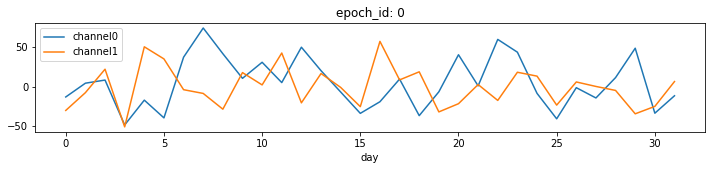

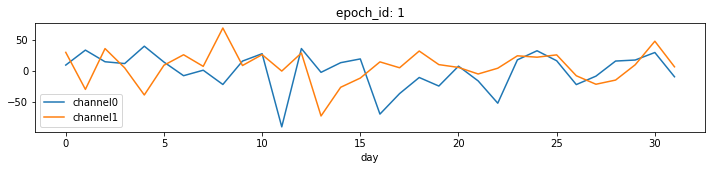

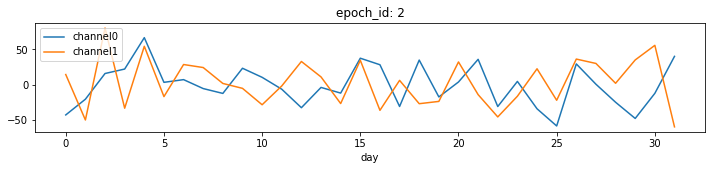

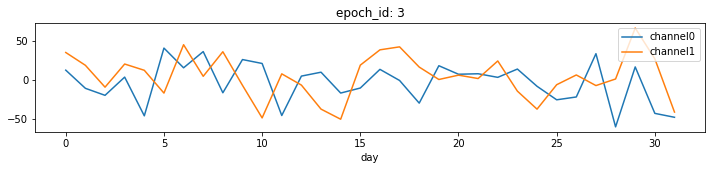

In [3]:
import pandas as pd
print("Simulated data")
for epoch_i, data in sim_epochs_df.groupby('epoch_id'):
    f = data.plot(
        x='day',
        y=['channel0', 'channel1'], 
        title=f'epoch_id: {epoch_i}',
        figsize=(12,2)
    )

# `matplotlib.pyplot`

More work but flexible enough for publication quality figures.

There are lots of ways to slice the data for plotting. Some are easier, some are faster.

Example: Overplot single trial EEG

(292, 375, 4)


(100, 375, 4)


CPU times: user 873 ms, sys: 28.3 ms, total: 902 ms
Wall time: 892 ms


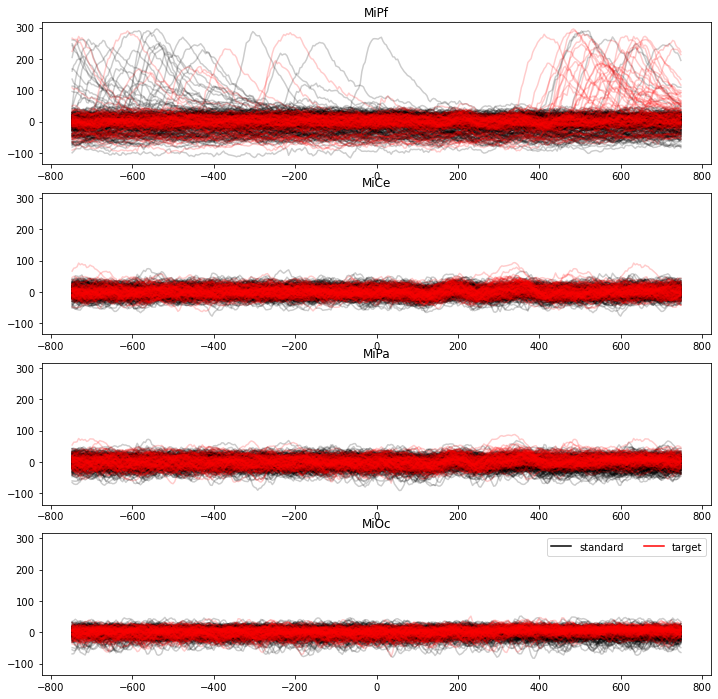

In [4]:
%%time

import copy
from matplotlib import pyplot as plt

f, axs = plt.subplots(4, 1, figsize=(12,12), sharey=True)
colors = {"standard": "black", "target": "red"}

time_stamps = eeg_epochs_df.time_ms.unique()
n_times = len(time_stamps)
n_channels = len(eeg_channels)
leg_h = []
for condition, trials in eeg_epochs_df.groupby('stim'):
    
    # reshape the epochs x channel 2-D array for overplotting
    n_trials = len(trials)
    trial_arry = (
        trials[eeg_channels]
        .to_numpy()
        .reshape(int(n_trials / n_times), n_times, n_channels)
    )
    print(trial_arry.shape)  # confirm (epochs, times, channels)

    for chan_idx, channel in enumerate(eeg_channels):
        axs[chan_idx].set_title(channel)
        lines = axs[chan_idx].plot(
            time_stamps,
            trial_arry[:, :, chan_idx].squeeze().T, 
            color=colors[condition], 
            alpha=.2,
            label=condition
        )
        
    # build a custom legend on the way out
    leg_line = copy.copy(lines[0]) # so we don't change the original line
    leg_line.set_alpha(1.0)
    leg_h.append(leg_line)
    
leg = axs[-1].legend(handles=leg_h, loc='upper right', ncol=2);

CPU times: user 4.14 s, sys: 35.4 ms, total: 4.18 s
Wall time: 4.17 s


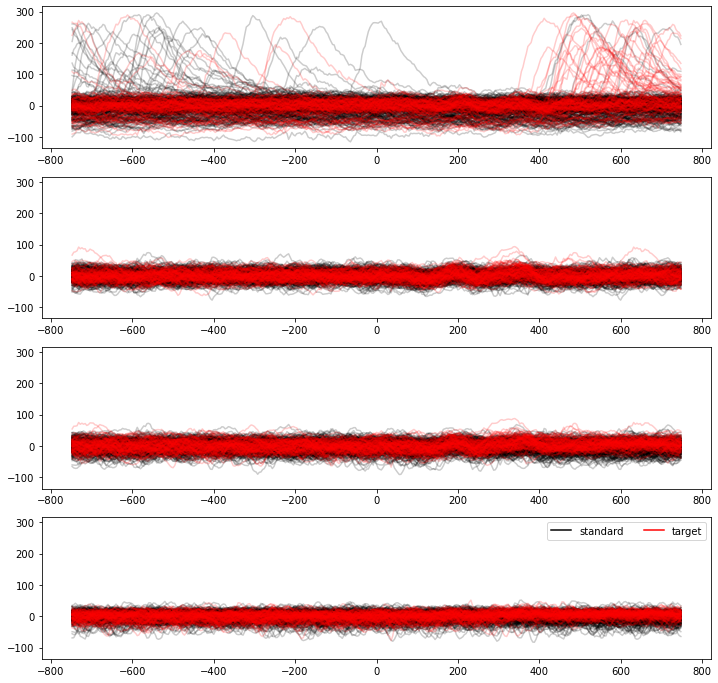

In [5]:
%%time

f, axs = plt.subplots(4, 1, figsize=(12,12), sharey=True)
colors = {"standard": "black", "target": "red"}

leg_h = []
for condition, trials in eeg_epochs_df.groupby('stim'):
    for epoch_idx, trial in trials.groupby('epoch_id'):            
        for chan_idx, channel in enumerate(eeg_channels):
            line = axs[chan_idx].plot(
                eeg_epochs_df.time_ms.unique(),
                trial[eeg_channels].to_numpy()[:, chan_idx], 
                color=colors[condition],
                alpha=.2,
                label=condition
            )
        
    # on way out, build custom legend handles current line
    leg_line = copy.copy(line[0])
    leg_line.set_alpha(1.0)
    leg_h.append(leg_line)
    
leg = axs[-1].legend(handles=leg_h, loc='upper right', ncol=2);

# Preview epochs rows and columns

The default display is to preview five lines of the head and tail.

In [6]:
display(sim_epochs_df)

,epoch_id,day,categorical,continuous,channel0,channel1,channel2,channel3
0,0,0,cat0,0.771321,-13.170787,-30.197057,19.609869,43.177612
1,0,1,cat0,0.020752,4.233125,-7.726009,-65.298259,41.464399
2,0,2,cat0,0.633648,8.191480,21.915223,18.568468,27.639613
3,0,3,cat0,0.748804,-48.557122,-50.952045,14.317029,-17.186617
4,0,4,cat0,0.498507,-17.193401,50.222266,0.782896,38.251473
...,...,...,...,...,...,...,...,...
123,3,27,cat1,0.744603,33.167254,-7.658414,14.630878,14.329468
124,3,28,cat1,0.469785,-60.531560,0.774228,1.689442,0.882024
125,3,29,cat1,0.598256,16.216221,66.028993,16.373534,4.854384
126,3,30,cat1,0.147620,-43.268966,26.531028,-20.493672,-12.327708


# Select rows to display with pandas `index` and `query`

Show day 4 in each epoch

In [7]:
display(sim_epochs_df.query("day==4"))

,epoch_id,day,categorical,continuous,channel0,channel1,channel2,channel3
4,0,4,cat0,0.498507,-17.193401,50.222266,0.782896,38.251473
36,1,4,cat1,0.113984,40.336483,-38.094588,-26.743542,-40.420244
68,2,4,cat0,0.330719,66.751489,54.533478,-50.413378,37.444479
100,3,4,cat1,0.578136,-46.419162,11.901780,46.354853,17.120804


Show epoch 2, all 32 days

In [8]:
display(sim_epochs_df.query("epoch_id==2"))

,epoch_id,day,categorical,continuous,channel0,channel1,channel2,channel3
64,2,0,cat0,0.039282,-42.626415,14.550079,15.875708,-6.495748
65,2,1,cat0,0.357182,-20.368403,-49.758141,-26.884315,-35.376135
66,2,2,cat0,0.079613,16.016544,80.397309,-5.934304,49.342834
67,2,3,cat0,0.305460,22.319232,-33.105664,-2.864275,21.702876
68,2,4,cat0,0.330719,66.751489,54.533478,-50.413378,37.444479
69,2,5,cat0,0.773830,3.515443,-16.681420,20.301246,21.981773
70,2,6,cat0,0.039959,7.338436,28.731337,1.821835,-9.630682
71,2,7,cat0,0.429492,-5.318965,24.456620,-0.691236,15.026849
72,2,8,cat0,0.314927,-12.171886,1.929582,-16.599553,15.598269
73,2,9,cat0,0.636491,23.453256,-4.992161,-33.183697,-41.336275


# Unhide rows and columns

Use `pandas.option_context` to control the number of rows and columns displayed

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sim_epochs_df)

,epoch_id,day,categorical,continuous,channel0,channel1,channel2,channel3
0,0,0,cat0,0.771321,-13.170787,-30.197057,19.609869,43.177612
1,0,1,cat0,0.020752,4.233125,-7.726009,-65.298259,41.464399
2,0,2,cat0,0.633648,8.191480,21.915223,18.568468,27.639613
3,0,3,cat0,0.748804,-48.557122,-50.952045,14.317029,-17.186617
4,0,4,cat0,0.498507,-17.193401,50.222266,0.782896,38.251473
5,0,5,cat0,0.224797,-39.613426,34.911711,-29.091170,-9.864961
6,0,6,cat0,0.198063,37.086160,-3.977208,-29.511844,-4.390224
7,0,7,cat0,0.760531,73.959752,-8.707374,12.375981,31.753099
8,0,8,cat0,0.169111,41.496967,-28.605973,-18.429145,-3.332413
9,0,9,cat0,0.088340,10.386993,17.641218,25.112453,-1.166434
